In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import re
import copy

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.4.5.post1 anndata==0.7.1 umap==0.3.9 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


In [2]:
PROTEIN='TP53'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
results_prefix=DATA+'/'+PROTEIN+'/processed_data/A549.'+PROTEIN


In [3]:
bcldirs=['180515_SL-HXR_0665_AFCHH2H3CCXY','180515_SL-HXS_0555_AFCHGYTGCCXY',
        '180515_SL-HXR_0666_BFCHGY7FCCXY','180515_SL-HXS_0556_BFCHH2FNCCXY']

for channel in range(32):
    print(channel)
    channelname=str(channel+1)
    for bcldir in bcldirs:
        gbc_cbc_file='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/data/count_barcodes/mismatches2/'+bcldir+'/A549_'+re.sub(PROTEIN,'p53',PROTEIN)+'_'+channelname+'.'+bcldir+'.variantBarcodeCounts.gz.with_cellbc_and_UMI.gz'
        cur_data=pd.read_csv(gbc_cbc_file,compression='gzip',sep='\t',header=None)
        cur_data.columns=['gbc','r2','pos','strand','cbc','umi','alignments','read_name']
        cur_data['cbc']=cur_data['cbc']+'ch'+str(channel)
        if channel==0:
            gbc_data=cur_data
        else:
            gbc_data=pd.concat([gbc_data,cur_data])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [4]:
import copy
gbc_data_original=copy.deepcopy(gbc_data)
gbc_data_original=gbc_data_original.drop_duplicates()
gbc_data_original.shape

(1492103, 8)

In [5]:
#keep only vbcs that map to - strand for vbcs, and to + strand for puro res
keep=[]
strand=list(gbc_data_original['strand'])
gbc=list(gbc_data_original['gbc'])
for i in range(gbc_data_original.shape[0]):
    cur_strand=strand[i]
    cur_gbc=gbc[i]
    if cur_strand=='-' and gbc!='Puro_res':
        keep.append(i)
    else:
        if cur_strand=='+' and gbc=='Puro_res':
            keep.append(i)
print('keep',len(keep),'total',gbc_data_original.shape[0])

gbc_data_filtered=copy.deepcopy(gbc_data_original)
gbc_data_filtered=gbc_data_filtered.iloc[keep,:]

keep 1131670 total 1492103


In [6]:
def compute_TPT(gbcs_dataset):
    
    '''
    input: pandas data frame with the columns "cbc", "umi", "gbc", "r2" where every row is a read 
    output: pandas data frame with the columns "gbc", "cbc", "umi", "cbc-umi-r2-count", "cbc-umi-count", "TPT"
    NOTE: for the input, multiple reads corresponding to the same cbc-umi combination should be listed as separate lines!
    '''

    import copy
    import re
    import time

    print("======== annotating cbc-umi pairs, and cbc-umi-r2")
    gbcs_dataset['cbcumi']=[x+'-'+y for x,y in zip(gbcs_dataset['cbc'],gbcs_dataset['umi'])]
    cbcumir2=list([x+'+'+y for x,y in zip(gbcs_dataset['cbcumi'],gbcs_dataset['r2'])])
    gbcs_dataset['cbcumir2']=list([x+'_gbc_'+y for x,y in zip(cbcumir2,gbcs_dataset['gbc'])])

    print("======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi")
    cbcumi_group=gbcs_dataset.groupby('cbcumi').size()
    cbcumi_r2_group=gbcs_dataset.groupby('cbcumir2').size()
    cbcumi_from_grouped_reads=[x.split('+')[0] for x in cbcumi_r2_group.index]

    print("======== computing TPT")
    #divide every cbc-umi-r2 value by the cbc-umi values 
    combo_counts=pd.DataFrame({'cbc-umi-r2':cbcumi_r2_group,
                              'cbc-umi-r2-name':cbcumi_r2_group.index,
                              'cbc-umi':cbcumi_from_grouped_reads})
    combo_counts['cbc-umi-total']=copy.deepcopy(list(cbcumi_group.loc[combo_counts['cbc-umi']]))
    combo_counts['TPT']=1.0*combo_counts['cbc-umi-r2']/combo_counts['cbc-umi-total']
    
    combo_counts['gbc']=list([x.split('_gbc_')[1] for x in list(combo_counts.loc[:,'cbc-umi-r2-name'])])
    combo_counts['umi']=list([x.split('-')[1] for x in list(combo_counts['cbc-umi'])])
    combo_counts['cbc']=list([x.split('-')[0] for x in list(combo_counts['cbc-umi'])])
    
    print("======== compiling the final result")
    to_return=pd.DataFrame({'gbc':combo_counts['gbc'],
                           'cbc':combo_counts['cbc'],
                           'umi':combo_counts['umi'],
                           'cbc-umi-r2-count':combo_counts['cbc-umi-r2'],
                           'cbc-umi-count':combo_counts['cbc-umi-total'],
                           'TPT':combo_counts['TPT']})
    to_return=to_return.reset_index(drop=True)
    return(to_return)

gbc_data=compute_TPT(gbc_data_filtered)

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result


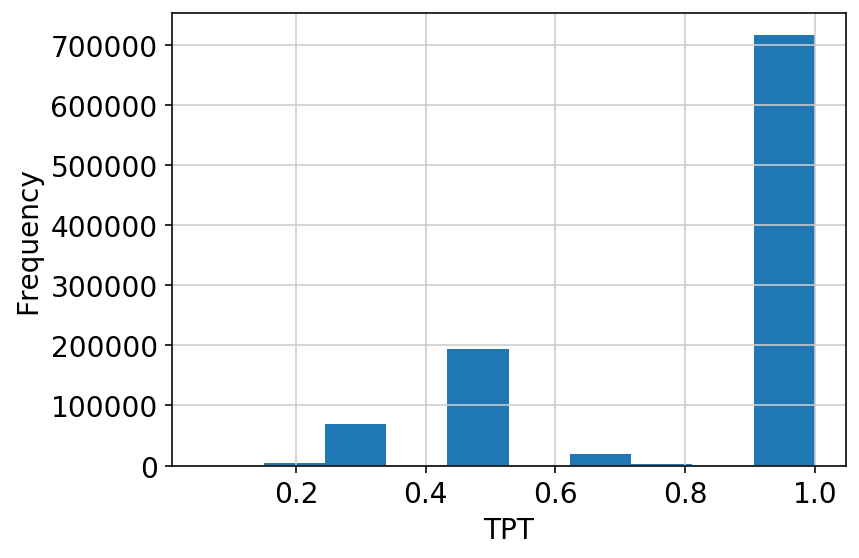

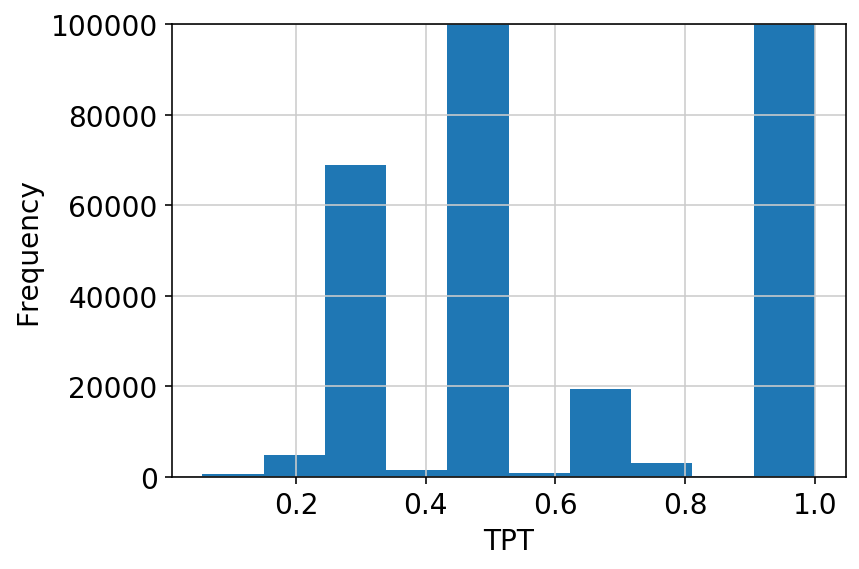

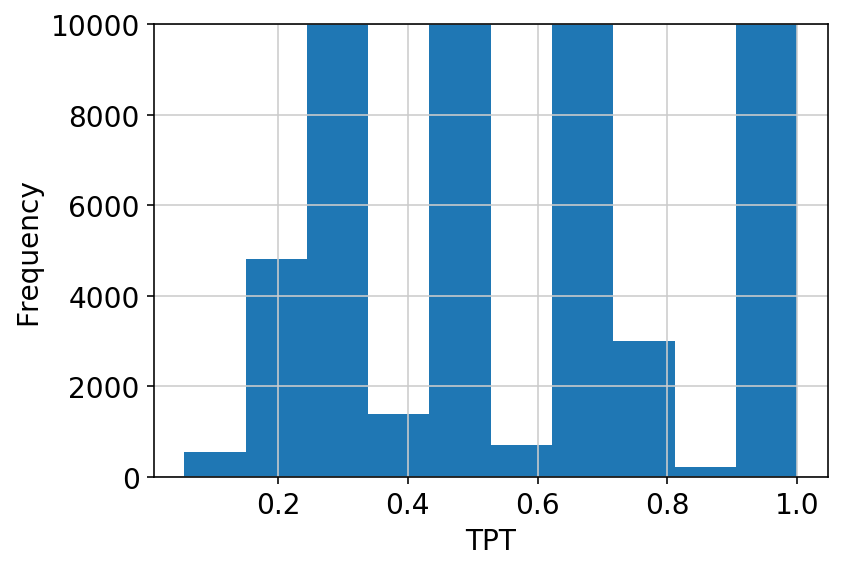

In [7]:
plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,100000)
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,10000)
plt.show()

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result


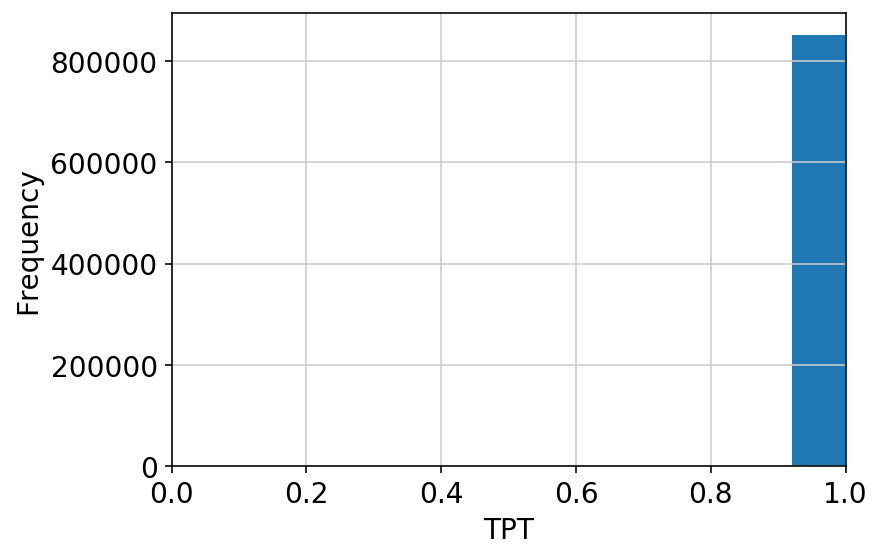

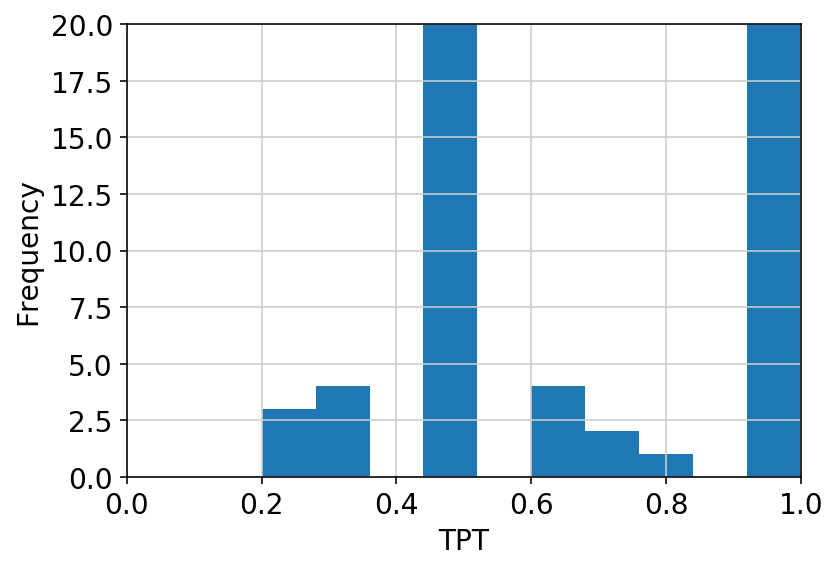

count    852458.000000
mean          0.999978
std           0.003451
min           0.200000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: TPT, dtype: float64


In [11]:
#now, compute lenient TPT that only looks at whether reads mapped to the same gbc, 
#even if they have diff sequences

gbc_data_filtered_lenient=copy.deepcopy(gbc_data_filtered)
gbc_data_filtered_lenient['r2']=gbc_data_filtered_lenient['gbc']
gbc_data=compute_TPT(gbc_data_filtered_lenient)

plt.hist(gbc_data['TPT'],10)
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.xlim(0,1)
plt.show()

plt.hist(gbc_data['TPT'],10)
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,20)
plt.xlim(0,1)
plt.show()

print(gbc_data['TPT'].describe())

In [12]:
#quickly look at the reads with bad TPTs
#there are v few of them (yay!)

gbc_data.loc[gbc_data['TPT']<1,:].head()

,gbc,cbc,umi,cbc-umi-r2-count,cbc-umi-count,TPT
29031,Puro_res,AAGCAGTGGTATCAACch12,GCAGAGTACA,2,3,0.666667
29032,TP53_p.Glu339Lys,AAGCAGTGGTATCAACch12,GCAGAGTACA,1,3,0.333333
188527,TP53_R273L,ATTTCTGGTTCCTCCAch28,TCCACCCTCA,1,2,0.500000
188528,TP53_V272L,ATTTCTGGTTCCTCCAch28,TCCACCCTCA,1,2,0.500000
205649,TP53_E286K,CACACCTAGCTGATAAch22,TAAGGTGAGT,1,2,0.500000


Filter to keep TPT==1
==

In [13]:
outpath=results_prefix+'.anno'
gbc_data.to_csv(outpath+'.vbc_TPT.gz',compression='gzip',index=False)

In [14]:
TPT_threshold=1.0

counts_with_tpt=pd.read_csv(outpath+'.vbc_TPT.gz',compression='gzip')
print(counts_with_tpt.head())

keep=list([x>=TPT_threshold for x in counts_with_tpt['TPT']])
filtered=counts_with_tpt[keep]
print(filtered.shape)
print(filtered.head())

          gbc                   cbc         umi  cbc-umi-r2-count  \
0  TP53_G266R  AAAAATGTCGCTAGCGch22  GATCGATCAT                 1   
1  TP53_R282W  AAAACAAGTTGGTTTGch17  TAGGTGTAGC                 1   
2  TP53_M246V  AAAACTGGTGGGTATGch17  TAGTCGGCGC                 1   
3  TP53_C275Y  AAAAGATGGTCACCTAch14  AAATTTAGTA                 1   
4  TP53_C275Y   AAAAGCAAAGCGGCTTch6  CTTGTCCACC                 1   

   cbc-umi-count  TPT  
0              1  1.0  
1              1  1.0  
2              1  1.0  
3              1  1.0  
4              1  1.0  
(852420, 6)
          gbc                   cbc         umi  cbc-umi-r2-count  \
0  TP53_G266R  AAAAATGTCGCTAGCGch22  GATCGATCAT                 1   
1  TP53_R282W  AAAACAAGTTGGTTTGch17  TAGGTGTAGC                 1   
2  TP53_M246V  AAAACTGGTGGGTATGch17  TAGTCGGCGC                 1   
3  TP53_C275Y  AAAAGATGGTCACCTAch14  AAATTTAGTA                 1   
4  TP53_C275Y   AAAAGCAAAGCGGCTTch6  CTTGTCCACC                 1   

   cbc-umi-cou

In [15]:
filtered_counts=filtered.groupby(['cbc','gbc','umi']).sum()
print(filtered_counts.shape)
filtered_counts.head()

filtered_counts.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_counts.gz',compression='gzip')

filtered_counts=pd.read_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_counts.gz',compression='gzip')
print(filtered_counts.shape)
filtered_counts.head()

#go through each line, make 2 matrices
#one gives us the total reads per cbc-gbc, one gives us the umis.

umi_counts={}
read_counts={}
for i in range(filtered_counts.shape[0]):
    if i%100000==0:
        print(i)
    cbc=filtered_counts.loc[i,'cbc']
    gbc=filtered_counts.loc[i,'gbc']
    umi=filtered_counts.loc[i,'umi']
    count=filtered_counts.loc[i,'cbc-umi-count']
    if cbc not in umi_counts:
        umi_counts[cbc]={}
        read_counts[cbc]={}
    if gbc not in umi_counts[cbc]:
        umi_counts[cbc][gbc]=set()
        read_counts[cbc][gbc]=0
    umi_counts[cbc][gbc].add(umi)
    read_counts[cbc][gbc]+=count
    
cbcs=list(set(filtered_counts['cbc']))
gbcs=list(set(filtered_counts['gbc']))
m_reads=np.zeros((len(cbcs),len(gbcs)))
m_umis=np.zeros((len(cbcs),len(gbcs)))
for cbc_idx in range(len(cbcs)):
    if cbc_idx%10000==0:
        print(cbc_idx)
    cbc=cbcs[cbc_idx]
    for gbc_idx in range(len(gbcs)):
        gbc=gbcs[gbc_idx]
        if cbc in umi_counts:
            if gbc in umi_counts[cbc]:
                count=len(list(umi_counts[cbc][gbc]))
                m_umis[cbc_idx,gbc_idx]=count
                m_reads[cbc_idx,gbc_idx]=read_counts[cbc][gbc]

(852420, 3)
(852420, 6)
0
100000
200000
300000
400000
500000
600000
700000
800000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000


In [16]:
m_umis_df=pd.DataFrame(m_umis)
m_umis_df.index=cbcs
m_umis_df.columns=gbcs

m_reads_df=pd.DataFrame(m_reads)
m_reads_df.index=cbcs
m_reads_df.columns=gbcs

m_umis_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.gz',compression='gzip')
m_reads_df.to_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_read_counts.gz',compression='gzip')

In [17]:
m_umis_df=pd.read_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_umi_counts.gz',compression='gzip',index_col=0)
m_reads_df=pd.read_csv(outpath+'.vbc_TPTfiltered'+str(TPT_threshold)+'_read_counts.gz',compression='gzip',index_col=0)
print(m_umis_df.shape)
m_umis_df.head()

(252759, 101)


,KRAS_K5E,TP53_p.Al83Vl,TP53_R249M,TP53_p.Pro153Pro,TP53_H193Y,TP53_p.Asp21Asp,TP53_H179Y,TP53_Y234C,TP53_G245V,TP53_p.Thr118Thr,...,TP53_C238Y,TP53_I195T,TP53_H214R,TP53_G266R,TP53_M237I,TP53_C242F,TP53_R158H,TP53_p.Gly360Vl,TP53_C275F,TP53_R273C
AGGTCCGAGATGTTAGch25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
TACTCGCAGGAACTGCch8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
GCTCCTAAGTATCTCGch9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGAGTGGAGCACCGCTch30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CATGGCGGTACCGTATch28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


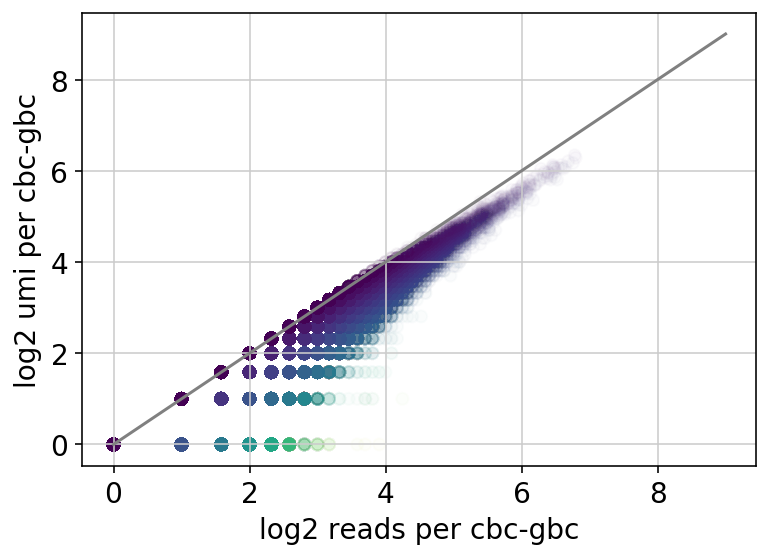

In [18]:
plt.scatter(np.log2(m_reads.flatten()[m_reads.flatten()>0.0]),
            np.log2(m_umis.flatten()[m_umis.flatten()>0.0]),alpha=0.02,
            c=np.log2(m_reads.flatten()[m_reads.flatten()>0.0])-np.log2(m_umis.flatten()[m_umis.flatten()>0.0]))
plt.xlabel('log2 reads per cbc-gbc')
plt.ylabel('log2 umi per cbc-gbc')
plt.plot(np.arange(0, 10), np.arange(0, 10),color='gray')
plt.show()

Annotate cells
==

In [19]:
#read in data
adata=sc.read(results_prefix+'.raw.h5ad')
adata

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


AnnData object with n_obs × n_vars = 192000 × 33694 
    obs: 'batch'

In [20]:
anno_cells=[]
cell_names=list(m_umis_df.index)
for i in range(m_umis_df.shape[0]):
    if i%10000==0:
        print(i)
    anno_cell=re.sub('ch','-1-',cell_names[i])
    anno_cells.append(anno_cell)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000


In [21]:
anno_cells_adata=list(set(adata.obs_names).intersection(set(anno_cells)))
print('annotated',len(anno_cells_adata),'total',len(adata.obs_names))

annotated 146181 total 192000


In [22]:
#now, go ahead and annotate the cells
m_umis_df.index=anno_cells
cell_names=list(m_umis_df.index)

anno_df=pd.DataFrame(np.zeros((len(adata.obs_names),len(m_umis_df.columns))))
anno_df.index=list(adata.obs_names)
anno_df.columns=list(m_umis_df.columns)

anno_df.loc[anno_cells_adata,:]=m_umis_df.loc[anno_cells_adata,list(m_umis_df)]
anno_df.sum()

KRAS_K5E                0.0
TP53_p.Al83Vl        5136.0
TP53_R249M           6072.0
TP53_p.Pro153Pro     6017.0
TP53_H193Y          11356.0
TP53_p.Asp21Asp      6647.0
TP53_H179Y          11631.0
TP53_Y234C           4651.0
TP53_G245V          10787.0
TP53_p.Thr118Thr     8215.0
TP53_G245S          10234.0
TP53_R110L           7505.0
TP53_V173L           8487.0
TP53_E285K           7336.0
TP53_R280T           9685.0
TP53_C277F          10947.0
TP53_p.Tyr107His     8703.0
TP53_P278S          15246.0
TP53_R273L           4803.0
TP53_V272M          11389.0
TP53_P278L           9585.0
TP53_p.Gln5Ar        4866.0
TP53_G105C           9635.0
TP53_R213Q           6636.0
TP53_S241F          12021.0
TP53_R248W           5751.0
TP53_S241C           5375.0
Puro_res             1543.0
TP53_p.Pro295Pro     5496.0
TP53_R158L           8600.0
                     ...   
TP53_p.Vl216Vl       6380.0
TP53_p.Ar158Ar       7378.0
TP53_p.Ser366Al      4548.0
TP53_R337C           7497.0
TP53_C275Y          

In [23]:
for gbc in list(m_umis_df.columns):
    adata.obs[gbc]=anno_df[gbc]

In [25]:
#also, annotate each cell with the mutant it has
gbcs=['TP53_p.Pro47Pro',
 'TP53_G105C',
 'TP53_H179R',
 'TP53_C275F',
 'TP53_R337L',
 'TP53_R273L',
 'TP53_G266V',
 'TP53_R158L',
 'TP53_C238Y',
 'TP53_S241F',
 'TP53_H193R',
 'TP53_C176F',
 'TP53_Y234C',
 'TP53_C275Y',
 'TP53_p.Vl216Vl',
 'TP53_H193Y',
 'TP53_p.Vl31Ile',
 'TP53_V173M',
 'TP53_C242F',
 'TP53_p.Pro301Pro',
 'KRAS_K5E',
 'TP53_C176Y',
 'TP53_R249S',
 'TP53_E286K',
 'TP53_R248W',
 'TP53_K132R',
 'TP53_R110L',
 'TP53_R249M',
 'TP53_R280T',
 'TP53_p.Pro36Pro',
 'TP53_C135F',
 'TP53_G245C',
 'TP53_C135Y',
 'TP53_L194R',
 'TP53_p.Glu2Glu',
 'TP53_K132N',
 'TP53_H193L',
 'TP53_p.Thr170Thr',
 'TP53_p.Pro222Pro',
 'TP53_V173L',
 'TP53_V157F',
 'TP53_p.Tyr107His',
 'TP53_R273H',
 'TP53_R248L',
 'TP53_E285K',
 'TP53_p.Ser366Al',
 'TP53_p.Glu339Lys',
 'TP53_p.Al83Vl',
 'TP53_p.Asp21Asp',
 'TP53_G266E',
 'TP53_Y236C',
 'TP53_C238F',
 'TP53_R280K',
 'TP53_I195T',
 'TP53_V272L',
 'TP53_P250L',
 'TP53_P151S',
 'TP53_Y220C',
 'TP53_G154V',
 'TP53_p.Thr312Ser',
 'TP53_p.Pro153Pro',
 'TP53_p.Thr118Thr',
 'TP53_p.Gly360Vl',
 'TP53_M246V',
 'TP53_G245V',
 'TP53_R273C',
 'TP53_p.Pro295Pro',
 'TP53_C277F',
 'TP53_A159V',
 'TP53_G244C',
 'TP53_G245S',
 'TP53_G266R',
 'TP53_Y205C',
 'TP53_P278L',
 'TP53_p.Gln5Ar',
 'TP53_S241C',
 'TP53_S127F',
 'TP53_H214R',
 'TP53_V216M',
 'TP53_R175H',
 'TP53_E271K',
 'TP53_p.Leu344Leu',
 'TP53_C141Y',
 'TP53_R158H',
 'TP53_P152L',
 'TP53_R213Q',
 'TP53_V272M',
 'TP53_p.Pro47Ser',
 'TP53_R282W',
 'TP53_G245D',
 'TP53_WT',
 'TP53_Y163C',
 'TP53_M237I',
 'TP53_P278S',
 'TP53_R337C',
 'TP53_p.Pro359Pro',
 'TP53_A159P',
 'TP53_H179Y',
 'TP53_p.Pro58Ar',
 'TP53_p.Ar158Ar']
mutant=[]
for cell_idx in range(len(adata.obs_names)):
    if cell_idx%10000==0:
        print(cell_idx)
    cur_mutants=[]
    for gbc in gbcs:
        if adata.obs[gbc][cell_idx]>0:
            cur_mutants.append(gbc)
    if len(cur_mutants)==0:
        mutant.append('uninfected')
    elif len(cur_mutants)==1:
        mutant.append(cur_mutants[0])
    elif len(cur_mutants)>1:
        mutant.append('multiple')
    else:
        mutant.append('unannotated')
        

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [26]:
adata.obs['mutant']=mutant
adata

AnnData object with n_obs × n_vars = 192000 × 33694 
    obs: 'batch', 'KRAS_K5E', 'TP53_p.Al83Vl', 'TP53_R249M', 'TP53_p.Pro153Pro', 'TP53_H193Y', 'TP53_p.Asp21Asp', 'TP53_H179Y', 'TP53_Y234C', 'TP53_G245V', 'TP53_p.Thr118Thr', 'TP53_G245S', 'TP53_R110L', 'TP53_V173L', 'TP53_E285K', 'TP53_R280T', 'TP53_C277F', 'TP53_p.Tyr107His', 'TP53_P278S', 'TP53_R273L', 'TP53_V272M', 'TP53_P278L', 'TP53_p.Gln5Ar', 'TP53_G105C', 'TP53_R213Q', 'TP53_S241F', 'TP53_R248W', 'TP53_S241C', 'Puro_res', 'TP53_p.Pro295Pro', 'TP53_R158L', 'TP53_P250L', 'TP53_p.Thr312Ser', 'TP53_S127F', 'TP53_R248L', 'TP53_C141Y', 'TP53_V157F', 'TP53_p.Pro36Pro', 'TP53_C176F', 'TP53_R273H', 'TP53_Y220C', 'TP53_H193R', 'TP53_Y163C', 'TP53_R282W', 'TP53_K132N', 'TP53_R249S', 'TP53_E286K', 'TP53_H193L', 'TP53_A159P', 'TP53_G245C', 'TP53_L194R', 'TP53_p.Pro222Pro', 'TP53_V173M', 'TP53_M246V', 'TP53_G266V', 'TP53_Y205C', 'TP53_P152L', 'TP53_p.Leu344Leu', 'TP53_C238F', 'TP53_R175H', 'TP53_G266E', 'TP53_V216M', 'TP53_R337L', 'TP53_R

In [27]:
adata.write(results_prefix+'.raw.anno.h5ad')

... storing 'mutant' as categorical


In [28]:
print(mutant.count('uninfected'))
print(mutant.count('unannotated'))
print(mutant.count('multiple'))


45985
0
37788
